<a href="https://colab.research.google.com/github/Jugranada/Aprendizaje_Maquina/blob/main/talleres/Regresion_Housing09_22_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

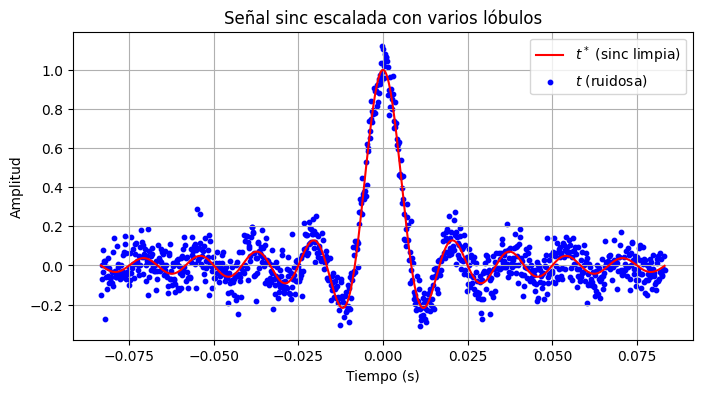

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Función var_snr
# ---------------------------
def var_snr(signal, snr_dB):
    Ps = np.mean(signal**2)  # potencia de la señal
    snr_linear = 10**(snr_dB/10)
    return Ps / snr_linear

# ---------------------------
# Parámetros
# ---------------------------
Fo = 60   # frecuencia fundamental
A = 1     # amplitud
Fs = 100*Fo  # frecuencia de muestreo

# ampliar el rango temporal: de -5 ciclos a 5 ciclos
t_min = -5/Fo
t_max =  5/Fo
X = np.arange(t_min, t_max, 1/Fs)

snrdB = 10  # SNR en dB

# ---------------------------
# Señal sinc escalada (limpia)
# np.sinc(x) = sin(pi*x)/(pi*x), por eso ajustamos argumento
# Queremos sin(2*pi*Fo*t)/(2*pi*Fo*t)
# que equivale a sinc(2*Fo*t)
# ---------------------------
tt = A * np.sinc(2 * Fo * X)

# ---------------------------
# Señal ruidosa
# ---------------------------
t = tt + np.sqrt(var_snr(tt, snrdB)) * np.random.randn(len(X))

# ---------------------------
# Formato para aprendizaje
# ---------------------------
X = X.reshape(-1, 1)
t = t.reshape(-1, 1)

# ---------------------------
# Gráfica
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(X, tt, c='r', label='$t^*$ (sinc limpia)')
plt.scatter(X, t, c='b', s=10, label='$t$ (ruidosa)')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal sinc escalada con varios lóbulos')
plt.grid(True)
plt.show()


In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# ---------------------------
# Funciones
# ---------------------------
def my_linGuassiano(X, t, phiQ, sig_eta, sig_w, tol=1e-16):
    Phi = phiQ.fit_transform(X)
    lambdaR = sig_eta / sig_w
    SNinv = Phi.T.dot(Phi) + lambdaR * np.eye(Phi.shape[1])  # covarianza inversa
    val, vec = np.linalg.eigh(SNinv)
    ind = val > tol
    SN = vec[:, ind].dot(np.diag(1/val[ind])).dot(vec[:, ind].T)
    mN = SN.dot(Phi.T.dot(t))
    return mN, SN, val

def my_predictivaLG(xnew, phiQ, mN, SN, sig_eta):
    Phinew = phiQ.fit_transform(xnew)
    mnew = Phinew.dot(mN)
    signew = np.diag(sig_eta*np.eye(Phinew.shape[0]) + Phinew.dot(SN).dot(Phinew.T))
    return mnew, signew

# ---------------------------
# Transformación polinómica
# ---------------------------
Q = 15  # grado del polinomio (aumentado para capturar la sinc)
phiQ = PolynomialFeatures(degree=Q)

# ---------------------------
# Particionar datos
# ---------------------------
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
    print("Split:", i)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

# ---------------------------
# Regresor lineal Gaussiano
# ---------------------------
sig_eta = 1
sig_w = 1e13  # varianza del prior de los pesos
mN, SN, val = my_linGuassiano(X[train_i], t[train_i], phiQ, sig_eta, sig_w)

# ---------------------------
# Predicción sobre datos de test
# ---------------------------
mnew, signew = my_predictivaLG(X[test_i], phiQ, mN, SN, sig_eta)

print("Predicción media shape:", mnew.shape)
print("Varianzas predictivas shape:", signew.shape)


Split: 0
Predicción media shape: (200, 1)
Varianzas predictivas shape: (200,)


<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-477237674.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(X, t, c='b', s=10, label='$t + \eta$ (ruido)')
/tmp/ipython-input-477237674.py:17: SyntaxWarning: invalid escape sequence '\p'
  alpha=0.2, color='gray', label='Incertidumbre $\pm \sigma$')


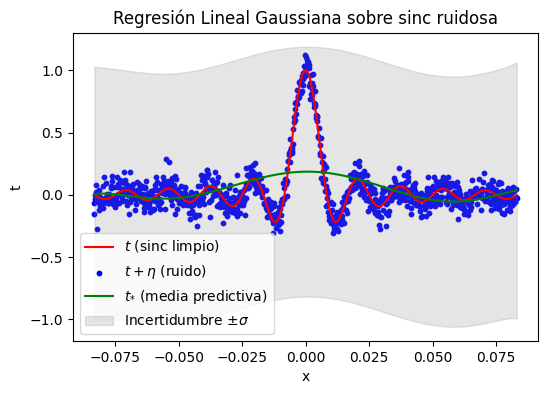

In [3]:
plt.figure(figsize=(6,4))

# señal limpia
plt.plot(X, tt, c='r', label='$t$ (sinc limpio)')

# señal con ruido
plt.scatter(X, t, c='b', s=10, label='$t + \eta$ (ruido)')

# predicción
plt.plot(X[test_i], mnew, c='g', label='$t_{*}$ (media predictiva)')

# bandas de confianza: usar desviación estándar
stdnew = np.sqrt(signew)
plt.fill_between(X[test_i].ravel(),
                 mnew.ravel() - stdnew,
                 mnew.ravel() + stdnew,
                 alpha=0.2, color='gray', label='Incertidumbre $\pm \sigma$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Regresión Lineal Gaussiana sobre sinc ruidosa')
plt.show()


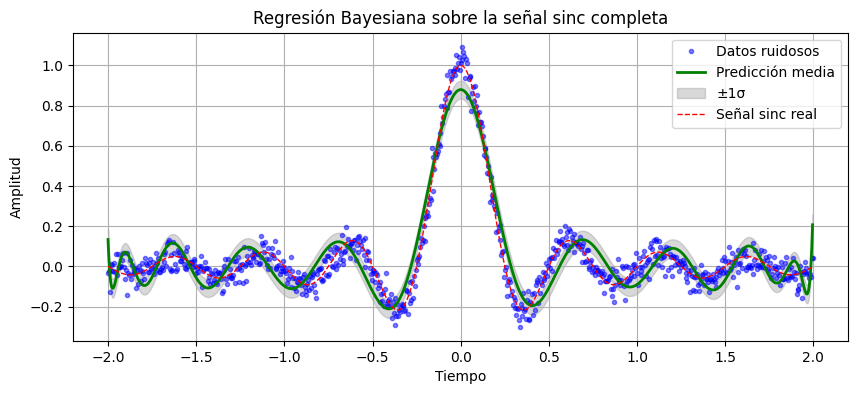

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.preprocessing import PolynomialFeatures

# --- Funciones auxiliares idénticas ---
def _invert_via_eigh(A, tol=1e-12):
    val, vec = np.linalg.eigh(A)
    ind = val > tol
    return vec[:, ind] @ np.diag(1.0/val[ind]) @ vec[:, ind].T

def my_posterior_update(Phi, t, sig_eta, sig_w, tol=1e-12):
    t = np.squeeze(t)
    beta = 1.0 / sig_eta
    alpha = 1.0 / sig_w
    SNinv = alpha * np.eye(Phi.shape[1]) + beta * (Phi.T @ Phi)
    SN = _invert_via_eigh(SNinv, tol)
    mN = beta * SN @ Phi.T @ t
    return mN, SN

def my_predictiva_update(Phinew, mN, SN, sig_eta):
    mnew = Phinew @ mN
    tmp = Phinew @ SN
    varnew = sig_eta + np.sum(tmp * Phinew, axis=1)
    return mnew.reshape(-1,1), varnew

# ---------------------------
# Señal sinc COMPLETA con ruido
# ---------------------------
Fo = 2       # frecuencia fundamental
A = 1
Fs = 200     # frecuencia de muestreo

# ---> Rango simétrico para ver toda la señal
X = np.arange(-2, 2, 1/Fs).reshape(-1,1)

# Señal sinc real (centrada)
tt = A * np.sinc(2 * Fo * X).ravel()

# Ruido
snrdB = 15
Ps = np.mean(tt**2)
sig_eta = Ps / (10**(snrdB/10))
t = tt + np.sqrt(sig_eta)*np.random.randn(len(X))

# ---------------------------
# Transformación polinómica
# ---------------------------
Q = 20
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)

# Prior
sig_w = 1e4

# Posterior Bayesiano
mN, SN = my_posterior_update(Phi, t, sig_eta, sig_w)

# Predicción en toda la malla
xgrid = np.linspace(X.min(), X.max(), 800).reshape(-1,1)
Phigrid = phiQ.transform(xgrid)
mnew, varnew = my_predictiva_update(Phigrid, mN, SN, sig_eta)

# ---------------------------
# Gráfica de la señal completa
# ---------------------------
plt.figure(figsize=(10,4))
plt.plot(X, t, 'b.', alpha=0.5, label='Datos ruidosos')
plt.plot(xgrid, mnew, 'g', lw=2, label='Predicción media')
plt.fill_between(xgrid.ravel(),
                 mnew.ravel()-np.sqrt(varnew),
                 mnew.ravel()+np.sqrt(varnew),
                 color='gray', alpha=0.3, label='±1σ')
plt.plot(X, tt, 'r--', lw=1, label='Señal sinc real')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Regresión Bayesiana sobre la señal sinc completa')
plt.legend()
plt.grid(True)
plt.show()


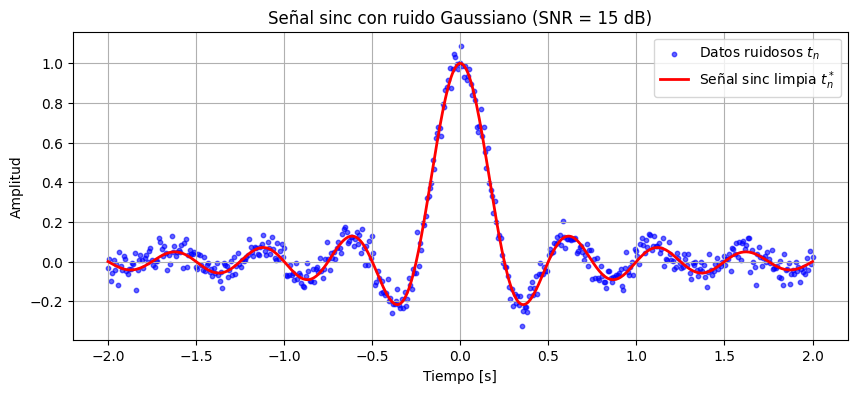

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Parámetros de la señal
# ---------------------------
Fo = 2      # frecuencia fundamental de la sinc
A  = 1      # amplitud
Fs = 200    # frecuencia de muestreo
N  = 500    # número de muestras
snrdB = 15   # relación señal/ruido en dB

# ---------------------------
# Generar dominio y señal sinc
# ---------------------------
# Rango simétrico para cubrir la señal completa
X = np.linspace(-2, 2, N).reshape(-1,1)

# Señal sinc "limpia" (objetivo)
tt = A * np.sinc(2 * Fo * X.ravel())

# ---------------------------
# Calcular varianza del ruido según SNR
# ---------------------------
def var_snr(signal, snr_db):
    """
    Calcula la varianza del ruido gaussiano para lograr
    una SNR deseada en dB.
    """
    Ps = np.mean(signal**2)                  # potencia de la señal
    return Ps / (10**(snr_db/10))            # varianza del ruido

sig_eta = var_snr(tt, snrdB)

# Añadir ruido Gaussiano
t = tt + np.sqrt(sig_eta) * np.random.randn(N)

# ---------------------------
# Graficar resultados
# ---------------------------
plt.figure(figsize=(10,4))
plt.scatter(X, t, s=10, c='b', alpha=0.6, label='Datos ruidosos $t_n$')
plt.plot(X, tt, 'r', lw=2, label='Señal sinc limpia $t_n^*$')
plt.title(f"Señal sinc con ruido Gaussiano (SNR = {snrdB} dB)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()


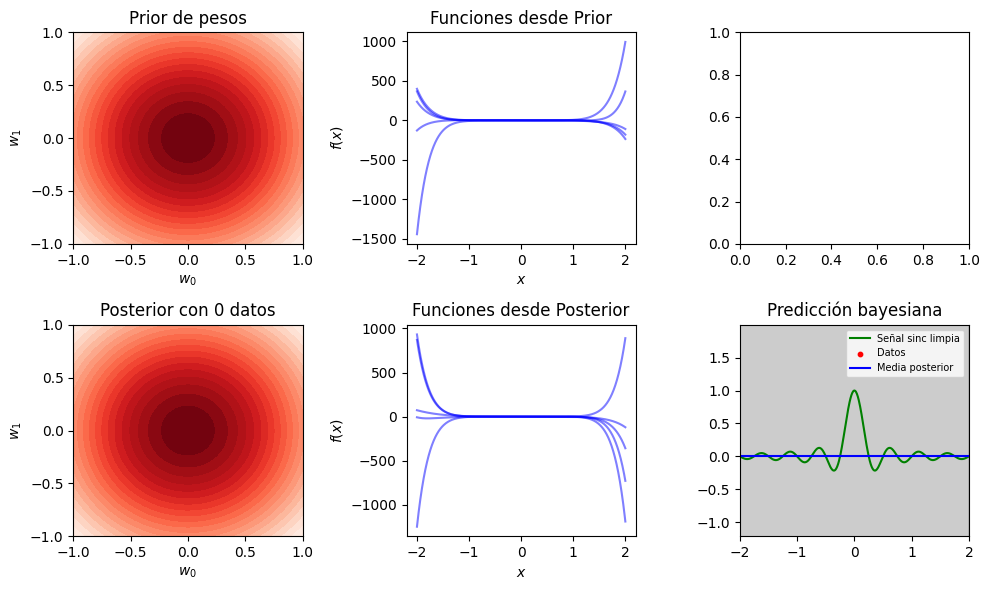

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import multivariate_normal

# ------------------------------------------------
# 1) Señal sinc ruidosa
# ------------------------------------------------
Fo = 2
A  = 1
N  = 500
snrdB = 5   # SNR en dB

X = np.linspace(-2, 2, N).reshape(-1,1)      # dominio (N,1)
tt = A * np.sinc(2 * Fo * X.ravel())         # señal limpia

def var_snr(signal, snr_db):
    Ps = np.mean(signal**2)
    return Ps / (10**(snr_db/10))

sig_eta = var_snr(tt, snrdB)
t = tt + np.sqrt(sig_eta) * np.random.randn(N)   # vector 1D de observaciones

# ------------------------------------------------
# 2) Transformación polinómica
# ------------------------------------------------
Q = 9  # grado del polinomio
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)

# ------------------------------------------------
# 3) Funciones auxiliares
# ------------------------------------------------
def _invert_via_eigh(A, tol=1e-12):
    val, vec = np.linalg.eigh(A)
    ind = val > tol
    return vec[:, ind] @ np.diag(1.0/val[ind]) @ vec[:, ind].T

def my_posterior_update(Phi, t, sig_eta, sig_w, tol=1e-12):
    """
    Calcula mN y SN para la regresión bayesiana.
    Asegura que t sea vector 1D.
    """
    t = np.asarray(t).reshape(-1)     # <--- Asegura vector 1D
    beta = 1.0 / sig_eta
    alpha = 1.0 / sig_w
    SNinv = alpha * np.eye(Phi.shape[1]) + beta * (Phi.T @ Phi)
    SN = _invert_via_eigh(SNinv, tol)
    mN = beta * SN @ (Phi.T @ t)
    return mN, SN

def my_predictiva_update(Phinew, mN, SN, sig_eta):
    """Media y desviación estándar predictiva."""
    mnew = Phinew @ mN
    tmp  = Phinew @ SN
    var  = sig_eta + np.sum(tmp * Phinew, axis=1)
    return mnew, np.sqrt(var)

def my_2Dpdf(mu, Sigma, axes, cmap='Reds', xlim=None, ylim=None):
    """Grafica la pdf 2D para las dos primeras componentes de los pesos."""
    mu2 = mu[:2]
    Sigma2 = Sigma[:2,:2]
    rv = multivariate_normal(mu2, Sigma2)
    if xlim is None:
        xlim = [mu2[0]-3*np.sqrt(Sigma2[0,0]), mu2[0]+3*np.sqrt(Sigma2[0,0])]
    if ylim is None:
        ylim = [mu2[1]-3*np.sqrt(Sigma2[1,1]), mu2[1]+3*np.sqrt(Sigma2[1,1])]
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    Xg, Yg = np.meshgrid(x, y)
    pos = np.empty(Xg.shape + (2,))
    pos[:,:,0] = Xg
    pos[:,:,1] = Yg
    Z = rv.pdf(pos)
    axes.contourf(Xg, Yg, Z, levels=20, cmap=cmap)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_xlabel('$w_0$')
    axes.set_ylabel('$w_1$')

def my_linregsyn(mu, Sigma, axes, xgrid, phiQ, Nmod=5):
    """Muestra varias funciones muestreadas de la distribución de pesos."""
    wmods = np.random.multivariate_normal(mu, Sigma, size=Nmod)
    Phi_g = phiQ.transform(xgrid)
    for w in wmods:
        y = Phi_g @ w
        axes.plot(xgrid, y, alpha=0.5, c='b')
    axes.set_xlabel('$x$')
    axes.set_ylabel('$f(x)$')

# ------------------------------------------------
# 4) Animación Bayesiana
# ------------------------------------------------
P = Phi.shape[1]
mu_w = np.zeros(P)
sig_w = 1.0
S_w = sig_w * np.eye(P)

# índices aleatorios para muestreo progresivo
ind = np.random.permutation(N)

# límites de ejes
wxlim = [-1, 1]
wylim = [-1, 1]
xlim  = [X.min(), X.max()]
ylim  = [tt.min()-1, tt.max()+1]

fig, ax = plt.subplots(2, 3, figsize=(10,6))
ax[0,2].axis('off')

def update(i):
    for a in ax.flat:
        a.cla()

    # prior
    my_2Dpdf(mu_w, S_w, axes=ax[0,0], xlim=wxlim, ylim=wylim)
    my_linregsyn(mu_w, S_w, axes=ax[0,1], xgrid=X, phiQ=phiQ)

    # datos hasta el paso i (siempre 2D para transform)
    Xi = X[ind[:i]].reshape(-1, 1)
    ti = t[ind[:i]].reshape(-1)        # <--- vector 1D

    # posterior
    if Xi.shape[0] > 0:
        Phii = phiQ.transform(Xi)
        mN, SN = my_posterior_update(Phii, ti, sig_eta, sig_w)
    else:
        mN, SN = mu_w, S_w

    my_2Dpdf(mN, SN, axes=ax[1,0], xlim=wxlim, ylim=wylim)
    my_linregsyn(mN, SN, axes=ax[1,1], xgrid=X, phiQ=phiQ)
    ax[1,1].scatter(Xi, ti, c='r', s=10)

    # predictiva
    mnew, snew = my_predictiva_update(phiQ.transform(X), mN, SN, sig_eta)
    ax[1,2].plot(X, tt, 'g', label='Señal sinc limpia')
    ax[1,2].scatter(Xi, ti, c='r', s=10, label='Datos')
    ax[1,2].plot(X, mnew, 'b', label='Media posterior')
    ax[1,2].fill_between(X.ravel(), mnew - 2*snew, mnew + 2*snew,
                         color='gray', alpha=0.4)
    ax[1,2].set_xlim(xlim)
    ax[1,2].set_ylim(ylim)

    # títulos
    ax[0,0].set_title('Prior de pesos')
    ax[0,1].set_title('Funciones desde Prior')
    ax[1,0].set_title(f'Posterior con {i} datos')
    ax[1,1].set_title('Funciones desde Posterior')
    ax[1,2].set_title('Predicción bayesiana')
    ax[1,2].legend(fontsize=7)
    plt.tight_layout()

# frames elegidos
frames = [0,1,2,5,10,20,50,100,200,400,N]
anim = animation.FuncAnimation(fig, update, frames=frames, interval=600, blit=False)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())


Mejor configuración encontrada:
   Grado polinómico: 20
   Varianza a priori sig_w: 1000.0
   MSE de validación: 0.008545


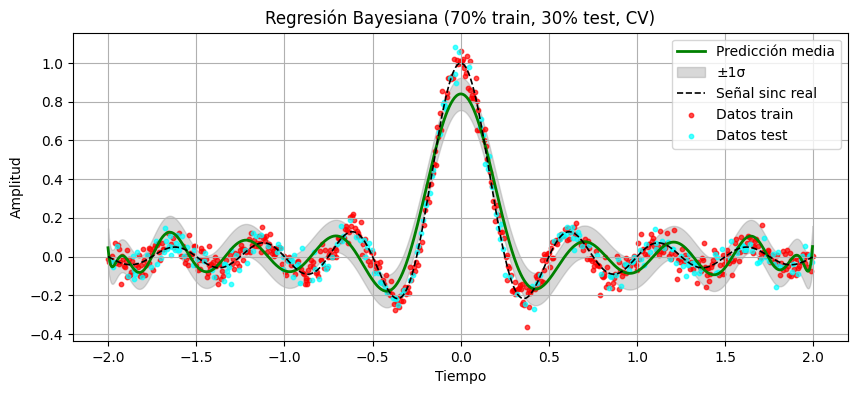

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold

# ---------------------------
# Funciones auxiliares
# ---------------------------
def _invert_via_eigh(A, tol=1e-12):
    val, vec = np.linalg.eigh(A)
    ind = val > tol
    return vec[:, ind] @ np.diag(1.0/val[ind]) @ vec[:, ind].T

def my_posterior_update(Phi, t, sig_eta, sig_w, tol=1e-12):
    t = np.squeeze(t)
    beta = 1.0 / sig_eta
    alpha = 1.0 / sig_w
    SNinv = alpha * np.eye(Phi.shape[1]) + beta * (Phi.T @ Phi)
    SN = _invert_via_eigh(SNinv, tol)
    mN = beta * SN @ Phi.T @ t
    return mN, SN

def my_predictiva_update(Phinew, mN, SN, sig_eta):
    mnew = Phinew @ mN
    tmp = Phinew @ SN
    varnew = sig_eta + np.sum(tmp * Phinew, axis=1)
    return mnew.reshape(-1,1), varnew

def estimate_noise_variance(Phi, y):
    """Estimación empírica de la varianza del ruido usando OLS residuals."""
    w_ols, *_ = np.linalg.lstsq(Phi, y, rcond=None)
    resid = y - Phi @ w_ols
    sigma2 = np.mean(resid**2)
    return float(sigma2)

# ---------------------------
# 1) Señal sinc completa
# ---------------------------
Fo = 2       # frecuencia fundamental
A = 1
Fs = 200     # frecuencia de muestreo

X = np.arange(-2, 2, 1/Fs).reshape(-1,1)
tt = A * np.sinc(2 * Fo * X).ravel()

snrdB = 15
Ps = np.mean(tt**2)
sig_eta = Ps / (10**(snrdB/10))
t = tt + np.sqrt(sig_eta)*np.random.randn(len(X))

# ---------------------------
# 2) Split 70% train / 30% test
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, t, train_size=0.7, random_state=42, shuffle=True
)

# ---------------------------
# 3) Validación cruzada para elegir grado y sig_w
# ---------------------------
degrees = [5, 10, 15, 20]                 # grados candidatos
sig_ws   = [1e-2, 1e-1, 1.0, 10.0, 1e3]   # varianzas a priori
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = np.inf
best_config = None

for Q in degrees:
    for sig_w_try in sig_ws:
        fold_mse = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            phi = PolynomialFeatures(degree=Q)
            Phi_tr = phi.fit_transform(X_tr)
            Phi_val = phi.transform(X_val)

            sig_eta_fold = estimate_noise_variance(Phi_tr, y_tr)
            mN_fold, SN_fold = my_posterior_update(Phi_tr, y_tr, sig_eta_fold, sig_w_try)
            mval, _ = my_predictiva_update(Phi_val, mN_fold, SN_fold, sig_eta_fold)
            mse = np.mean((mval.ravel() - y_val)**2)
            fold_mse.append(mse)

        mean_mse = np.mean(fold_mse)
        if mean_mse < best_score:
            best_score = mean_mse
            best_config = (Q, sig_w_try)

print("Mejor configuración encontrada:")
print(f"   Grado polinómico: {best_config[0]}")
print(f"   Varianza a priori sig_w: {best_config[1]}")
print(f"   MSE de validación: {best_score:.6f}")

# ---------------------------
# 4) Entrenar con todo el 70% usando la mejor configuración
# ---------------------------
best_Q, best_sig_w = best_config
phiQ = PolynomialFeatures(degree=best_Q)
Phi_train = phiQ.fit_transform(X_train)
Phi_test  = phiQ.transform(X_test)

sig_eta_train = estimate_noise_variance(Phi_train, y_train)
mN, SN = my_posterior_update(Phi_train, y_train, sig_eta_train, best_sig_w)

# ---------------------------
# 5) Predicción en toda la malla
# ---------------------------
xgrid = np.linspace(X.min(), X.max(), 800).reshape(-1,1)
Phigrid = phiQ.transform(xgrid)
mnew, varnew = my_predictiva_update(Phigrid, mN, SN, sig_eta_train)

# ---------------------------
# 6) Gráfica final
# ---------------------------
plt.figure(figsize=(10,4))
plt.plot(xgrid, mnew, 'g', lw=2, label='Predicción media')
plt.fill_between(xgrid.ravel(),
                 mnew.ravel() - np.sqrt(varnew),
                 mnew.ravel() + np.sqrt(varnew),
                 color='gray', alpha=0.3, label='±1σ')
plt.plot(X, tt, 'k--', lw=1.2, label='Señal sinc real')
plt.scatter(X_train, y_train, c='r', s=10, alpha=0.7, label='Datos train')
plt.scatter(X_test,  y_test,  c='cyan', s=10, alpha=0.7, label='Datos test')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Regresión Bayesiana (70% train, 30% test, CV)')
plt.legend()
plt.grid(True)
plt.show()


Mejor configuración (GridSearchCV):
  degree = 50
  alpha  = 1e-08
  CV MSE = 0.01961013007719585
MSE en test (30%): 1.597038e-02


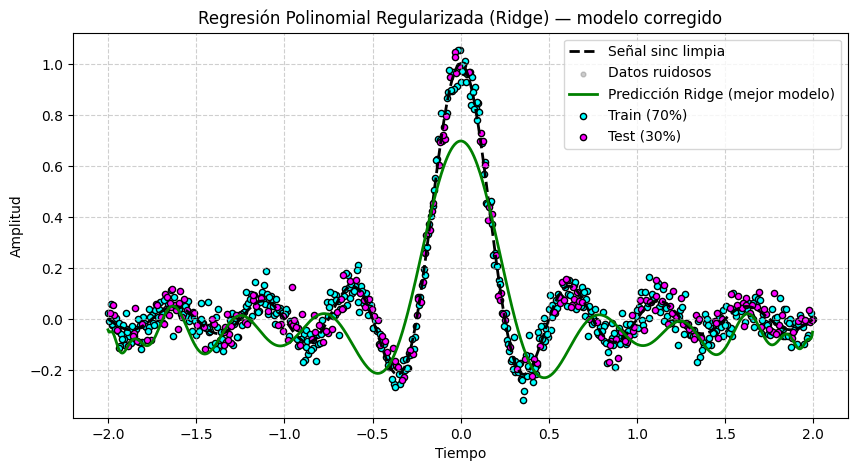

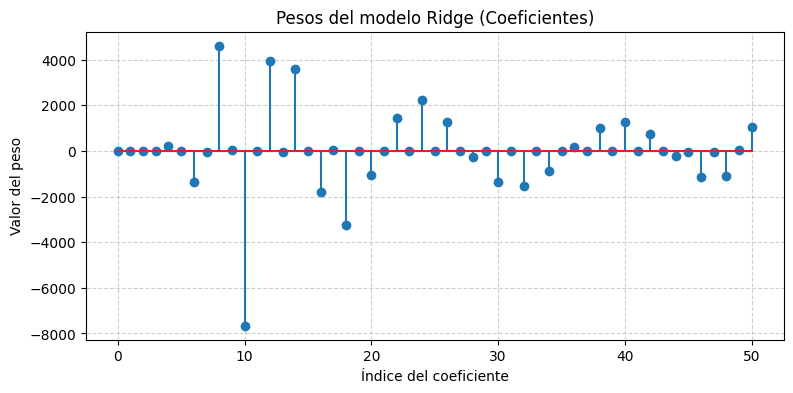

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# ---------------------------
# 1) Señal sinc (igual que antes)
# ---------------------------
Fo = 2
A = 1
Fs = 200

X = np.arange(-2, 2, 1/Fs).reshape(-1,1)
tt = A * np.sinc(2 * Fo * X).ravel()

snrdB = 15
Ps = np.mean(tt**2)
sig_eta = Ps / (10**(snrdB/10))
rng = np.random.RandomState(42)
t = tt + np.sqrt(sig_eta)*rng.randn(len(X))

# ---------------------------
# 2) Split 70% train / 30% test
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, t, train_size=0.7, random_state=42, shuffle=True
)

# ---------------------------
# 3) Grid search para grado y alpha (Ridge)
#    - Usamos Pipeline: PolynomialFeatures -> StandardScaler -> Ridge(fit_intercept=False)
#    - fit_intercept=False porque PolynomialFeatures añade bias (columna de 1s)
# ---------------------------
pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=True)),   # incluye término constante
    ("scaler", StandardScaler()),                     # estandariza columnas polinomiales
    ("ridge", Ridge(fit_intercept=False))             # no ajustar intercept de nuevo
])

param_grid = {
    "poly__degree": [5, 10, 15, 20, 30, 40, 50],
    # alphas desde muy pequeñas hasta moderadas (logspace)
    "ridge__alpha": np.logspace(-8, 2, 11)
}

cv = 5
gs = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

print("Mejor configuración (GridSearchCV):")
print("  degree =", gs.best_params_["poly__degree"])
print("  alpha  =", gs.best_params_["ridge__alpha"])
print("  CV MSE =", -gs.best_score_)

# ---------------------------
# 4) Entrenar modelo final con mejor configuración sobre todo el conjunto de entrenamiento
# ---------------------------
best_model = gs.best_estimator_
best_model.fit(X_train, y_train)

# Predicción sobre todo X (malla original ordenada)
t_pred_all = best_model.predict(X)

# Predicción sobre test para obtener métricas
y_test_pred = best_model.predict(X_test)
mse_test = np.mean((y_test - y_test_pred)**2)
print(f"MSE en test (30%): {mse_test:.6e}")

# ---------------------------
# 5) Graficar resultados
# ---------------------------
plt.figure(figsize=(10,5))
plt.plot(X, tt, 'k--', linewidth=2, label='Señal sinc limpia')
plt.scatter(X, t, c='gray', s=12, alpha=0.4, label='Datos ruidosos')

plt.plot(X, t_pred_all, 'g', linewidth=2, label='Predicción Ridge (mejor modelo)')

plt.scatter(X_train, y_train, c='cyan', s=20, edgecolors='k', label='Train (70%)')
plt.scatter(X_test, y_test, c='magenta', s=20, edgecolors='k', label='Test (30%)')

plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title("Regresión Polinomial Regularizada (Ridge) — modelo corregido")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# ---------------------------
# 6) Graficar coeficientes
# ---------------------------
# Extraemos coeficientes del paso 'ridge' del pipeline
ridge_coefs = best_model.named_steps["ridge"].coef_.ravel()

plt.figure(figsize=(9,4))
plt.stem(ridge_coefs)
plt.title('Pesos del modelo Ridge (Coeficientes)')
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del peso')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Regresion California Housing

In [9]:

from sklearn.datasets import fetch_california_housing
N = 1000 # # samples
P = 20 # # features
X, y = fetch_california_housing(return_X_y=True)
print(X.shape,y.shape)

(20640, 8) (20640,)


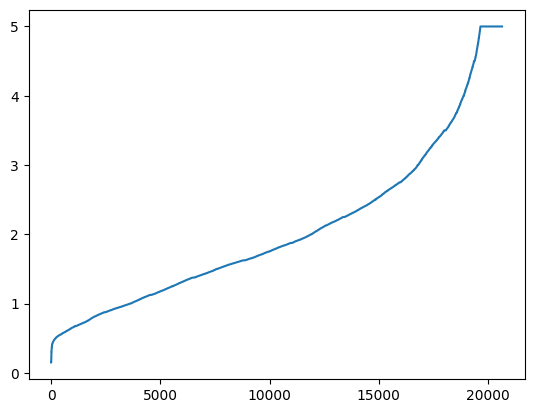

In [10]:
plt.plot(np.sort(y))
plt.show()


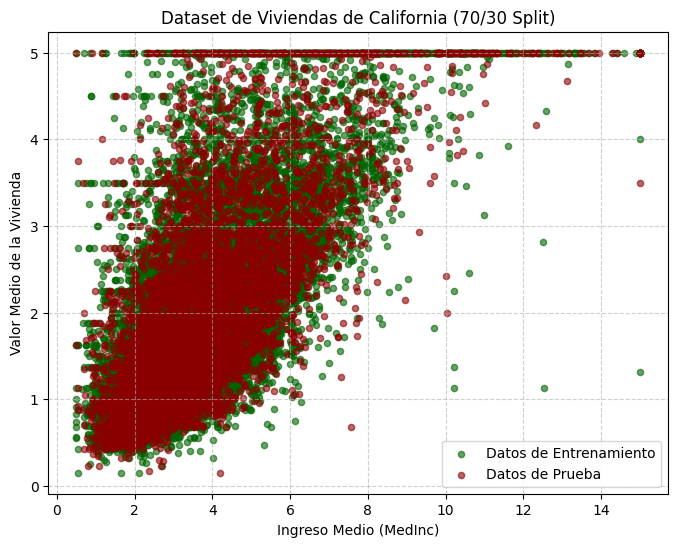

In [13]:
# ---------------------------------------------------------------------------
# BLOQUE 1: Visualización inicial de los datos
# ---------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, c="darkgreen", s=20, alpha=0.6, label="Datos de Entrenamiento")
plt.scatter(X_test, y_test, c="darkred", s=20, alpha=0.6, label="Datos de Prueba")
plt.xlabel("Ingreso Medio (MedInc)")
plt.ylabel("Valor Medio de la Vivienda")
plt.title("Dataset de Viviendas de California (70/30 Split)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


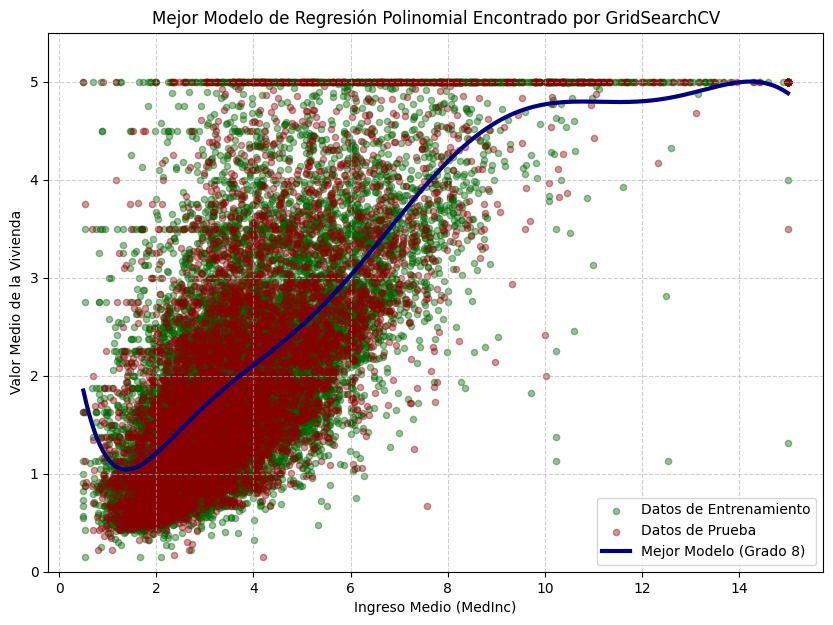

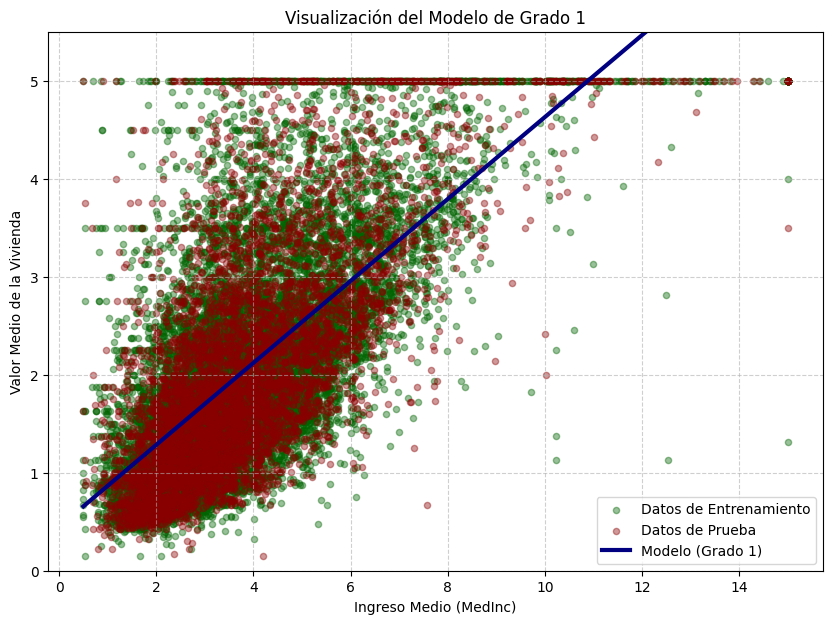

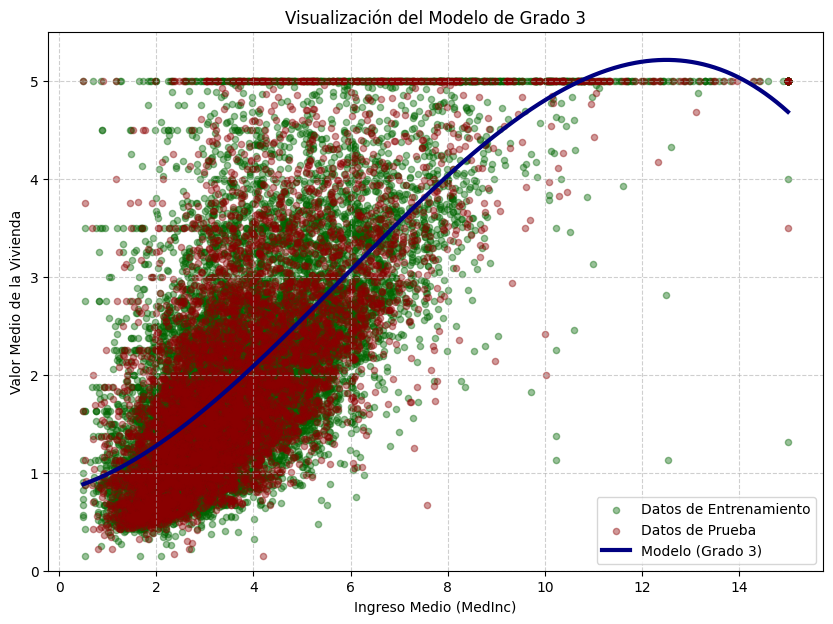

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.56481e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


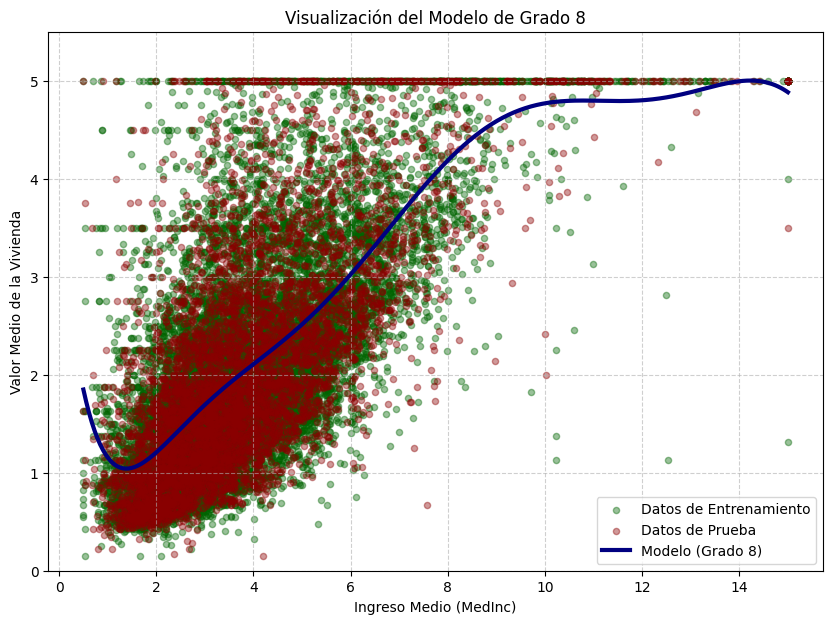

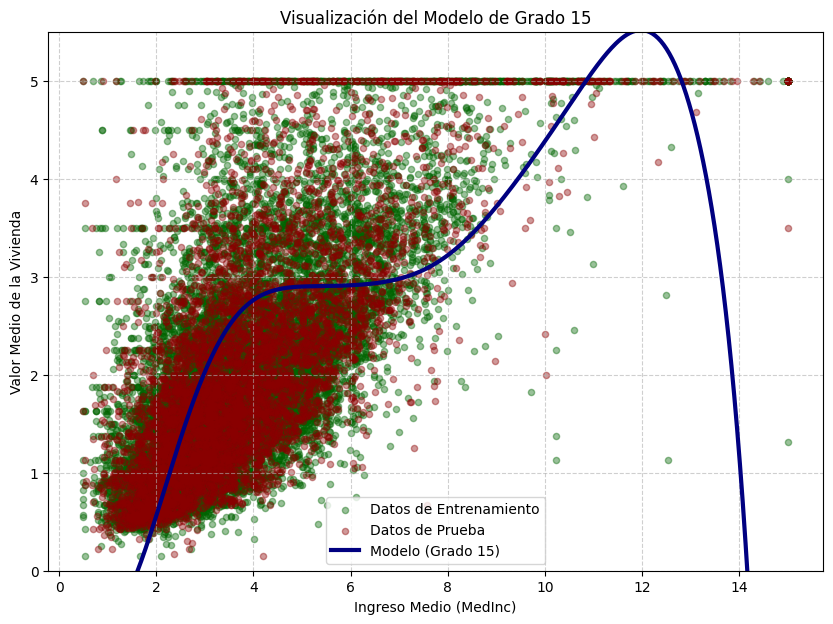

In [14]:
# ---------------------------------------------------------------------------
# BLOQUE 2: Visualización del mejor modelo y comparación de grados
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, c="darkgreen", s=20, alpha=0.4, label="Datos de Entrenamiento")
plt.scatter(X_test, y_test, c="darkred", s=20, alpha=0.4, label="Datos de Prueba")

X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_range_pred = best_model.predict(X_range)
plt.plot(X_range, y_range_pred, color='navy', linewidth=3, label=f'Mejor Modelo (Grado {best_degree})')

plt.title('Mejor Modelo de Regresión Polinomial Encontrado por GridSearchCV')
plt.xlabel('Ingreso Medio (MedInc)')
plt.ylabel('Valor Medio de la Vivienda')
plt.legend()
plt.ylim(0, 5.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ---------------------------------------------------------------------------
# Comparación de distintos grados
# ---------------------------------------------------------------------------
grados_a_comparar = [1, 3, best_degree, 15]
for grado in grados_a_comparar:
    modelo_especifico = Pipeline([
        ('poly', PolynomialFeatures(degree=grado, include_bias=False)),
        ('ridge', Ridge(alpha=best_alpha))
    ])
    modelo_especifico.fit(X_train, y_train)
    plt.figure(figsize=(10, 7))
    plt.scatter(X_train, y_train, c="darkgreen", s=20, alpha=0.4, label="Datos de Entrenamiento")
    plt.scatter(X_test, y_test, c="darkred", s=20, alpha=0.4, label="Datos de Prueba")
    y_range_pred = modelo_especifico.predict(X_range)
    plt.plot(X_range, y_range_pred, color='navy', linewidth=3, label=f'Modelo (Grado {grado})')
    plt.title(f'Visualización del Modelo de Grado {grado}')
    plt.xlabel('Ingreso Medio (MedInc)')
    plt.ylabel('Valor Medio de la Vivienda')
    plt.legend()
    plt.ylim(0, 5.5)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
